This file is one part of the response to coursework1 COMP0137

In [1]:
import glob

import matplotlib.pyplot as plt
import numpy as np

In [2]:
def getMixGaussLogLike(data, mixGaussEst):
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.

    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns:
    logLike -- scalar containing the log likelihood.

    """

    data = np.atleast_2d(data)
    # find total number of data items
    nDims, nData = data.shape

    # initialize log likelihoods
    logLike = 0

    # calculate
    for cData in range(nData):
        thisData = data[:, cData]
        like = 0
        for k in range(mixGaussEst['k']):
            sigma = mixGaussEst['cov'][:, :, k]
            mu = mixGaussEst['mean'][:, k]
            like = like + mixGaussEst['weight'][k] * getMultiGaussProb(thisData, mu, sigma)
        logLike = logLike + np.log(like)
    return logLike.item()


In [3]:
def getMoGLike(data, mixGaussEst):
    """
    This function calculate the likelihood of a single data
    Args:
        data: d by 1, data
        mixGaussEst: a dictionary containing all MoG parameters

    Returns:
        like: scaler, the likelihood of the data

    """
    data = np.atleast_2d(data)
    # find total number of data items
    nDims, nData = data.shape
    if nData != 1:
        return False
    like = 0
    # run through each data item
    for cData in range(nData):
        thisData = data[:, cData]
        like = 0
        for k in range(mixGaussEst['k']):
            sigma = mixGaussEst['cov'][:, :, k]
            mu = mixGaussEst['mean'][:, k]

            like = like + mixGaussEst['weight'][k] * getMultiGaussProb(thisData, mu, sigma)

    return like


In [4]:
def getMultiGaussProb(data, mu, sigma):
    try:
        nDim, nData = np.shape(data)
    except:
        nDim = np.size(data)
        data = data.reshape(nDim, 1)
        nDim, nData = data.shape

    A = 1 / ((2 * np.pi) ** (nDim / 2) * np.linalg.det(sigma) ** (0.5))

    B = np.exp(-0.5 * np.dot(np.dot((data - np.array([mu, ] * nData).transpose()).T, (np.linalg.inv(sigma))),
                             (data - np.array([mu, ] * nData).transpose())))
    prob = A * B
    return prob

In [5]:
def fitMixGauss(data, k):
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.


    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.

    Returns:
    mixGaussEst -- dict containing the estimated MoG parameters.

    """

    #     MAIN E-M ROUTINE
    #     In the E-M algorithm, we calculate a complete posterior distribution over
    #     the (nData) hidden variables in the E-Step.
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).
    print('im start')
    nDims, nData = data.shape
    postHidden = np.zeros(shape=(k, nData))
    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)

    cIter = 0
    logLike = getMixGaussLogLike(data, mixGaussEst)
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))

    continueFlag = 1
    while continueFlag == 1:
        cIter += 1
        # ===================== =====================
        # Expectation step
        # ===================== =====================

        for cData in range(nData):
            # TO DO (g) : fill in column of 'hidden' - calculate posterior probability that
            # this data point came from each of the Gaussians
            # replace this:
            prob = np.zeros([1, mixGaussEst['k']])
            # firstly we have to calculate the sum of all responsibilities
            #<debug>

            #</debug>

            for i in range(mixGaussEst['k']):
                mu = mixGaussEst['mean'][:, i]
                sigma = mixGaussEst['cov'][:, :, i]
                prob[0, i] = mixGaussEst['weight'][i] * getMultiGaussProb(data[:, cData], mu, sigma)
            postHidden[:, cData] = prob / np.sum(prob)

        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        for cGauss in range(k):
            # Update weighting parameters mixGauss.weight based on the total
            # posterior probability associated with each Gaussian. Replace this:
            mixGaussEst['weight'][cGauss] = np.sum(postHidden[cGauss, :]) / np.sum(postHidden[:])

            # Update mean parameters mixGauss.mean by weighted average
            # where weights are given by posterior probability associated with
            # Gaussian.  Replace this:
            mixGaussEst['mean'][:, cGauss] = np.dot(postHidden[cGauss, :], data.T) / np.sum(
                postHidden[cGauss, :])

            # Update covarance parameter based on weighted average of
            # square distance from update mean, where weights are given by
            # posterior probability associated with Gaussian
            a = np.sum(postHidden[cGauss, :])
            b = (data - np.array([mixGaussEst['mean'][:, cGauss], ] * data.shape[1]).transpose())
            num = np.dot(postHidden[cGauss, :] * b, b.transpose())
            mixGaussEst['cov'][:, :, cGauss] = num / a
        lastLogLike = logLike
        logLike = getMixGaussLogLike(data, mixGaussEst)
        if logLike - lastLogLike < 1:
            continueFlag = 0
        print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, logLike))
    return mixGaussEst

In [49]:
def plotROC(testData, tureSet):
    tureValue = np.array(testData)
    y = np.array(tureSet)
    thresholds = np.array((0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0))
    Positive = sum(y)
    Negative = len(y) - Positive
    FPR = []
    TPR = []
    for threshold in thresholds:
        FP = 0
        TP = 0
        for i in range(len(tureValue)):
            if tureValue[i] >= threshold:
                if y[i] == 1:
                    TP = TP + 1
                if y[i] == 0:
                    FP = FP + 1
        FPR.append(FP / Negative)
        TPR.append(TP / Positive)
    auc = -1 * np.trapz(TPR, FPR)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('AUC = %.2f' % auc)

    plt.plot(FPR, TPR, linestyle='--', marker='o', color='green')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.show()

Part II Task A
Step1: Load Data and preprocessing

In [6]:

tAppleFiles = glob.glob("apples/*.jpg")
tAppleMaskFiles = glob.glob("apples/*.png")

# Initialise two containers
tAppleImgs = []
tAppleMaskImgs = []

for myFile in tAppleFiles:
    tAppleImgs.append(plt.imread(myFile) / 255)

for myFile in tAppleMaskFiles:
    tAppleMaskImgs.append(plt.imread(myFile))

tApple = np.array(tAppleImgs, dtype=np.ndarray)
tAppleMask = np.array(tAppleMaskImgs, dtype=np.ndarray)
print('load success')
# Distinguish all Apple and Non-apple pixels
tAppleDataList = []
tAppleMaskDataList = []

# find all apple pixels and non apple pixels.
for im in range(np.size(tAppleMask)):
    #cut out trivial data
    tAppleMask[im] = tAppleMask[im][:, :, 0:3]
    # reshape data
    pixelY, pixelX, color = tApple[im].shape
    tAppleDataList.append(tApple[im].reshape([pixelY * pixelX, color]))
    tAppleMaskDataList.append(tAppleMask[im].reshape([pixelY * pixelX, color]))

load success


Part II Task B
Step2: Determine prior

In [7]:
tAppleData = np.vstack((tAppleDataList[0], tAppleDataList[1], tAppleDataList[2]))
tAppleMaskData = np.vstack((tAppleMaskDataList[0], tAppleMaskDataList[1], tAppleMaskDataList[2]))
# In case of non-regular values
tAppleIndex = np.where(tAppleMaskData[:, 0] >= 0.5)
tNonAppleIndex = np.where(tAppleMaskData[:, 0] < 0.5)
#debug
# test = np.where((tAppleMaskData[:, 0] > 0.5) & (tAppleMaskData[:, 0] < 0.5))
# print(tAppleMaskData[test])
#/debug
tNonAppleRGB = tAppleData[tNonAppleIndex]
tAppleRGB = tAppleData[tAppleIndex]

### calculate prior of two gaussian
priorNonApple = tAppleRGB.size / (tAppleRGB.size + tNonAppleRGB.size)
priorApple = 1 - priorNonApple

Part II Task C
Step3: Training and generating a MoG parameters dictionary

For your Convenience, I have put the result in the next cell, feel free to use it validating my other parts' code

In [8]:
# Calculate MoG paramters
NumAppleGauss = 3
NumNonAppleGauss = 3
MoGApple = fitMixGauss(tAppleRGB.transpose(), NumAppleGauss)
MoGNonApple = fitMixGauss(tNonAppleRGB.transpose(), NumNonAppleGauss)

im start
Log Likelihood Iter 0 : -2618370.708

Log Likelihood After Iter 1 : 292706.901

Log Likelihood After Iter 2 : 310581.538

Log Likelihood After Iter 3 : 352156.887

Log Likelihood After Iter 4 : 420127.531

Log Likelihood After Iter 5 : 524078.093

Log Likelihood After Iter 6 : 585872.284

Log Likelihood After Iter 7 : 615549.131

Log Likelihood After Iter 8 : 630820.875

Log Likelihood After Iter 9 : 640164.069

Log Likelihood After Iter 10 : 646906.969

Log Likelihood After Iter 11 : 652292.218

Log Likelihood After Iter 12 : 656940.192

Log Likelihood After Iter 13 : 661240.505

Log Likelihood After Iter 14 : 665421.466

Log Likelihood After Iter 15 : 669514.053

Log Likelihood After Iter 16 : 673347.039

Log Likelihood After Iter 17 : 676680.718

Log Likelihood After Iter 18 : 679389.892

Log Likelihood After Iter 19 : 681520.713

Log Likelihood After Iter 20 : 683217.552

Log Likelihood After Iter 21 : 684637.831

Log Likelihood After Iter 22 : 685919.285

Log Likelihood A

Stored MoG parameters for debug in order to save time
They are generated by function 'fitMixGauss'

In [8]:
MoGApple = dict()
MoGNonApple = dict()
MoGApple['d'] = 3
MoGApple['k'] = 3
MoGApple['weight'] = np.array([0.32095376, 0.47288429, 0.20616194])
MoGApple['mean'] = np.array([[0.43822128, 0.6151519, 0.6406526],
                             [0.10909276, 0.58504691, 0.69456609],
                             [0.08028633, 0.3553861, 0.07337287]])
MoGApple['cov'] = np.array([[[0.03239161, 0.04123016, 0.00925913],
                             [0.00560379, 0.02314693, 0.00858658],
                             [0.00870745, 0.04072354, 0.00610813]],

                            [[0.00560379, 0.02314693, 0.00858658],
                             [0.00845214, 0.04581284, 0.00822849],
                             [0.00508146, 0.03924075, 0.00546179]],

                            [[0.00870745, 0.04072354, 0.00610813],
                             [0.00508146, 0.03924075, 0.00546179],
                             [0.00550668, 0.0599463, 0.00692947]]])

MoGNonApple['d'] = 3
MoGNonApple['k'] = 3
MoGNonApple['weight'] = np.array([0.03086717, 0.46691742, 0.50221542])
MoGNonApple['mean'] = np.array([[0.72994559, 0.46429305, 0.42421817],
                                [0.74240735, 0.33684098, 0.40618113],
                                [0.1678624, 0.13907806, 0.38943957]])
MoGNonApple['cov'] = np.array([[[0.00720227, 0.04365309, 0.10966543],
                                [0.00637633, 0.03623422, 0.11038906],
                                [0.00761588, 0.01972718, 0.11096918]],

                               [[0.00637633, 0.03623422, 0.11038906],
                                [0.00596075, 0.04393084, 0.11356185],
                                [0.00663745, 0.02130537, 0.11529232]],

                               [[0.00761588, 0.01972718, 0.11096918],
                                [0.00663745, 0.02130537, 0.11529232],
                                [0.0108518, 0.02224245, 0.12077755]]])


Step4: Apply MoG model to test pictures

In [52]:
testAppleFile = glob.glob("testApples/*.jpg")
testAppleImgs = []
# Load pictures
for myFile in testAppleFile:
    thisImg = np.array(plt.imread(myFile)) / 255
    thisImg = thisImg[:, :, 0:3]
    testAppleImgs.append(thisImg)

#Calculate posterior probability for each pixels
posteriorApple = []
for i in range(np.size(testAppleImgs)):
    thisAppleData = testAppleImgs[i]
    imY, imX, imZ = thisAppleData.shape
    posteriorApple.append(np.zeros([imY, imX]))
    print(imY, imX)
    for cY in range(imY):
        print('Processing Row ', cY, '\n')
        for cX in range(imX):
            #extract this pixel's data
            thisPixelData = np.double(thisAppleData[cY, cX, :])
            thisPixelData = thisPixelData[:, np.newaxis]
            likeApple = getMoGLike(thisPixelData, MoGApple)
            likeNonApple = getMoGLike(thisPixelData, MoGNonApple)
            posteriorApple[i][cY, cX] = (likeApple * priorApple) / (
                    likeApple * priorApple + likeNonApple * priorNonApple)
    print('calculation finished')

/Users/andrew.zhou/opt/anaconda3/envs/mv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3202: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


1500 2000
Processing Row  0 

Processing Row  1 

Processing Row  2 

Processing Row  3 

Processing Row  4 

Processing Row  5 

Processing Row  6 

Processing Row  7 

Processing Row  8 

Processing Row  9 

Processing Row  10 

Processing Row  11 

Processing Row  12 

Processing Row  13 

Processing Row  14 

Processing Row  15 

Processing Row  16 

Processing Row  17 

Processing Row  18 

Processing Row  19 

Processing Row  20 

Processing Row  21 

Processing Row  22 

Processing Row  23 

Processing Row  24 

Processing Row  25 

Processing Row  26 

Processing Row  27 

Processing Row  28 

Processing Row  29 

Processing Row  30 

Processing Row  31 

Processing Row  32 

Processing Row  33 

Processing Row  34 

Processing Row  35 

Processing Row  36 

Processing Row  37 

Processing Row  38 

Processing Row  39 

Processing Row  40 

Processing Row  41 

Processing Row  42 

Processing Row  43 

Processing Row  44 

Processing Row  45 

Processing Row  46 

Processing Ro

Step5: plot the result

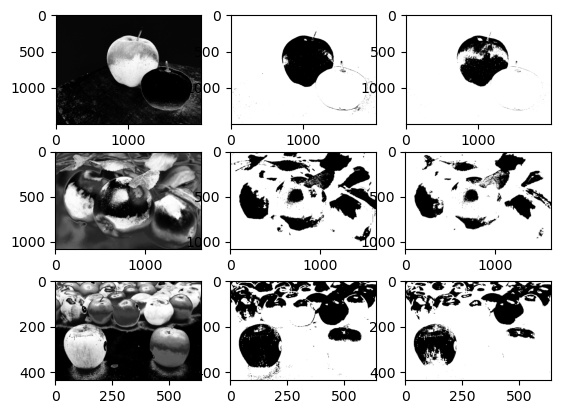

In [28]:
# Plot TestApples
# Container
threshold1 = 0.5
threshold2 = 0.7
bound1 = 1
bound2 = 0
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3)
y1, x1 = posteriorApple[0].shape
y2, x2 = posteriorApple[1].shape
y3, x3 = posteriorApple[2].shape
im1 = np.ones([y1, x1, 3])
im2 = np.ones([y1, x1, 3])
im3 = np.ones([y1, x1, 3])
im4 = np.ones([y2, x2, 3])
im5 = np.ones([y2, x2, 3])
im6 = np.ones([y2, x2, 3])
im7 = np.ones([y3, x3, 3])
im8 = np.ones([y3, x3, 3])
im9 = np.ones([y3, x3, 3])

pixelAppleIndex1 = []
pixelAppleIndex2 = []
for im in posteriorApple:
    index1 = np.where(im[:, :] > threshold1)
    index2 = np.where(im[:, :] > threshold2)
    pixelAppleIndex1.append(index1)
    pixelAppleIndex2.append(index2)

im1 = np.array([posteriorApple[0][:, :].transpose(), ] * 3).transpose()
im4 = np.array([posteriorApple[1][:, :].transpose(), ] * 3).transpose()
im7 = np.array([posteriorApple[2][:, :].transpose(), ] * 3).transpose()
im2[pixelAppleIndex1[0]] = np.zeros([[len(a) for a in pixelAppleIndex1[0]][0], 3])
im5[pixelAppleIndex1[1]] = np.zeros([[len(a) for a in pixelAppleIndex1[1]][0], 3])
im8[pixelAppleIndex1[2]] = np.zeros([[len(a) for a in pixelAppleIndex1[2]][0], 3])
im3[pixelAppleIndex2[0]] = np.zeros([[len(a) for a in pixelAppleIndex2[0]][0], 3])
im6[pixelAppleIndex2[1]] = np.zeros([[len(a) for a in pixelAppleIndex2[1]][0], 3])
im9[pixelAppleIndex2[2]] = np.zeros([[len(a) for a in pixelAppleIndex2[2]][0], 3])

ax1.imshow(im1)
ax2.imshow(im2)
ax3.imshow(im3)
ax4.imshow(im4)
ax5.imshow(im5)
ax6.imshow(im6)
ax7.imshow(im7)
ax8.imshow(im8)
ax9.imshow(im9)

plt.savefig('test3Dims.jpg')

For the first image, whose results are shown in the first line, we can see that the model is able to identify the apple very well. However, for the second image, the model we have is confused about the ambiguity between leaves and apples. So it works badly.
As for the last picture, red apples can be easily recognized. But model works not so well on distinguishing green and yellow apples

Part II Task D: ROC analysis for Apple,

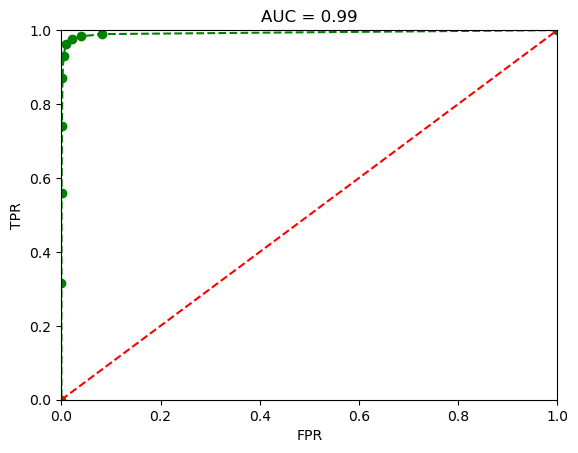

In [53]:
############################
#       Task: ROC          #
############################
tureSet = plt.imread('testApples/Bbr98ad4z0A-ctgXo3gdwu8-original.png')
# regularization
ySet, xSet, colorSet = tureSet.shape
tureSet = tureSet.reshape(ySet * xSet, 3)
tureSet = tureSet[:, 0]
indexTrue = np.where(tureSet >= 0.5)
indexFalse = np.where(tureSet < 0.5)
tureSet[indexTrue] = np.ones(len(indexTrue))
tureSet[indexFalse] = np.zeros(len(indexFalse))
testData = posteriorApple[0].reshape(ySet * xSet)
plotROC(testData, tureSet)

As is mentioned above, the model works very well on the first figure. The closer the green line is close to top-left conner, the better the model's performance is.

PartII E

In [54]:
myAppleFile = glob.glob("myApples/*.jpeg")
myAppleImgs = []

for myFile in myAppleFile:
    thisImg = np.array(plt.imread(myFile)) / 255
    thisImg = thisImg[:, :, 0:3]
    myAppleImgs.append(thisImg)


In [55]:
posteriorApple = []

for i in range(len(myAppleImgs)):
    thisAppleData = myAppleImgs[i]
    imY, imX, imZ = thisAppleData.shape
    posteriorApple.append(np.zeros([imY, imX]))
    print(imY, imX)
    for cY in range(imY):
        print('Processing Row ', cY, '\n')
        for cX in range(imX):
            #extract this pixel's data
            thisPixelData = np.double(thisAppleData[cY, cX, :])
            thisPixelData = thisPixelData[:, np.newaxis]
            likeApple = getMoGLike(thisPixelData, MoGApple)
            likeNonApple = getMoGLike(thisPixelData, MoGNonApple)
            posteriorApple[i][cY, cX] = (likeApple * priorApple) / (
                    likeApple * priorApple + likeNonApple * priorNonApple)
    print('calculation finished')

480 640
Processing Row  0 

Processing Row  1 

Processing Row  2 

Processing Row  3 

Processing Row  4 

Processing Row  5 

Processing Row  6 

Processing Row  7 

Processing Row  8 

Processing Row  9 

Processing Row  10 

Processing Row  11 

Processing Row  12 

Processing Row  13 

Processing Row  14 

Processing Row  15 

Processing Row  16 

Processing Row  17 

Processing Row  18 

Processing Row  19 

Processing Row  20 

Processing Row  21 

Processing Row  22 

Processing Row  23 

Processing Row  24 

Processing Row  25 

Processing Row  26 

Processing Row  27 

Processing Row  28 

Processing Row  29 

Processing Row  30 

Processing Row  31 

Processing Row  32 

Processing Row  33 

Processing Row  34 

Processing Row  35 

Processing Row  36 

Processing Row  37 

Processing Row  38 

Processing Row  39 

Processing Row  40 

Processing Row  41 

Processing Row  42 

Processing Row  43 

Processing Row  44 

Processing Row  45 

Processing Row  46 

Processing Row 

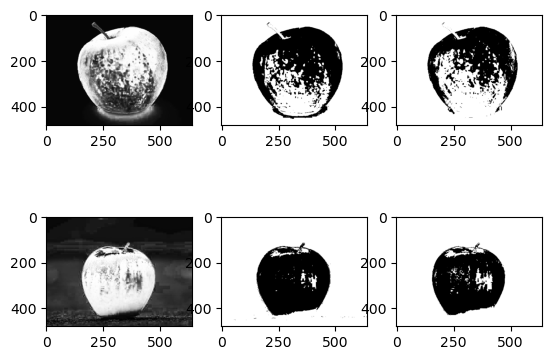

In [45]:
threshold1 = 0.5
threshold2 = 0.7
bound1 = 1
bound2 = 0
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)
y1, x1 = posteriorApple[0].shape
y2, x2 = posteriorApple[1].shape

im1 = np.ones([y1, x1, 3])
im2 = np.ones([y1, x1, 3])
im3 = np.ones([y1, x1, 3])
im4 = np.ones([y2, x2, 3])
im5 = np.ones([y2, x2, 3])
im6 = np.ones([y2, x2, 3])

pixelAppleIndex1 = []
pixelAppleIndex2 = []
for im in posteriorApple:
    index1 = np.where(im[:, :] > threshold1)
    index2 = np.where(im[:, :] > threshold2)
    pixelAppleIndex1.append(index1)
    pixelAppleIndex2.append(index2)

im1 = np.array([posteriorApple[0][:, :].transpose(), ] * 3).transpose()
im4 = np.array([posteriorApple[1][:, :].transpose(), ] * 3).transpose()
im2[pixelAppleIndex1[0]] = np.zeros([[len(a) for a in pixelAppleIndex1[0]][0], 3])
im5[pixelAppleIndex1[1]] = np.zeros([[len(a) for a in pixelAppleIndex1[1]][0], 3])
im3[pixelAppleIndex2[0]] = np.zeros([[len(a) for a in pixelAppleIndex2[0]][0], 3])
im6[pixelAppleIndex2[1]] = np.zeros([[len(a) for a in pixelAppleIndex2[1]][0], 3])

ax1.imshow(im1)
ax2.imshow(im2)
ax3.imshow(im3)
ax4.imshow(im4)
ax5.imshow(im5)
ax6.imshow(im6)

plt.savefig('my3Dims.jpg')

The model we have works comparatively well to this two pictures. It mainly because the picture is simple and there is no other disturbance in picture. However, we can see that a portion of apples' pixels are not recognized. This maybe due to the texture of this apple is not common in training set, or even doesn't exist in training set. So, they didn't be marked as apple.

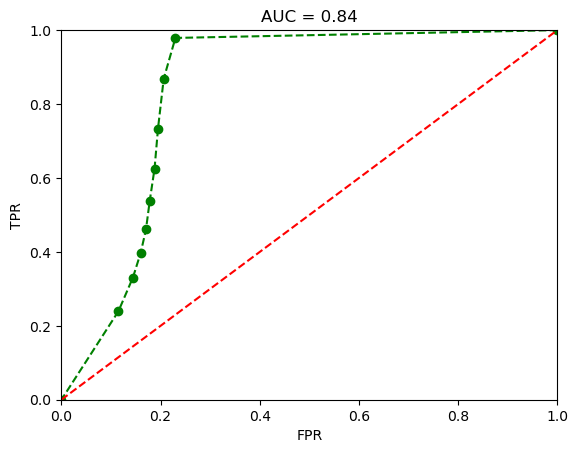

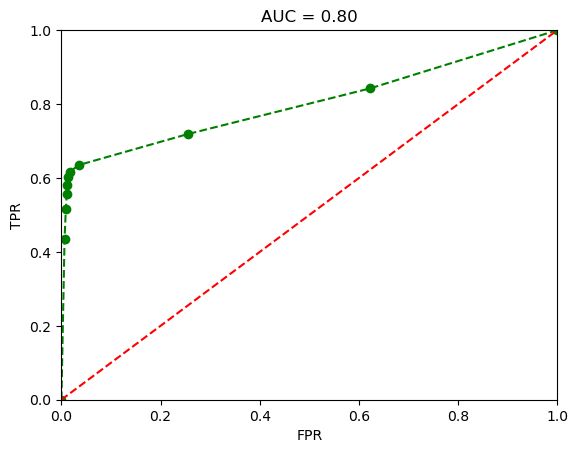

In [50]:
############################
#       Task: ROC          #
############################
tureSet1 = plt.imread('myApples/MyApple0B.png')
tureSet2 = plt.imread('myApples/MyApple1B.png')
# regularization
ySet1, xSet1, colorSet1 = tureSet1.shape
ySet2, xSet2, colorSet2 = tureSet2.shape
tureSet1 = tureSet1.reshape(ySet1 * xSet1, 3)
tureSet2 = tureSet2.reshape(ySet2 * xSet2, 3)
tureSet1 = tureSet1[:, 0]
tureSet2 = tureSet2[:, 0]
indexTrue1 = np.where(tureSet1 >= 0.5)
indexTrue2 = np.where(tureSet2 >= 0.5)
indexFalse1 = np.where(tureSet1 < 0.5)
indexFalse2 = np.where(tureSet2 < 0.5)
tureSet1[indexTrue1] = np.ones(len(indexTrue1))
tureSet2[indexTrue2] = np.ones(len(indexTrue2))
tureSet1[indexFalse1] = np.zeros(len(indexFalse1))
tureSet2[indexFalse2] = np.zeros(len(indexFalse2))
testData1 = posteriorApple[0].reshape(ySet1 * xSet1)
testData2 = posteriorApple[1].reshape(ySet2 * xSet2)

plotROC(testData1, tureSet1)
plotROC(testData2, tureSet2)

Part II Task F:
We definetly need all the three kinds of sets. If we just have training set, we could not know how the performance of the model is. If we don't have validation set, then, we don't know the performance got from testing is right or not. And, the testing set can help us to evaluate the model, finding it is suitable for further usage or not.